# Scraping Data from Twitter
This was done using the second tier of academic access (thank you twitter!) and snscrape to utilize search functions.

## Setup

In [ ]:
# pip install tweepy
# pip install configparser
# pip install pandas
# pip install snscrape

In [54]:
import tweepy
import configparser
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
%matplotlib inline

# Setting up Config & Authentication

In [16]:
# Read Config file - you will need to create one of these
config = configparser.ConfigParser()
config.read('config/config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [17]:
# Authentication
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

## Grabbing followers of account

In [19]:
# Search Parameters
screen_name = "SchmidhuberAI"
follow_list = []
follow_id_list = []
follower_limit = 3000
  
# Populating lists with follower names and IDs using twitter API
for page in tweepy.Cursor(api.get_followers, screen_name=screen_name, count=100).items(follower_limit):
#     print(page.screen_name)
    follow_list.append(page.screen_name)
    follow_id_list.append(page.id)

TooManyRequests: 429 Too Many Requests
88 - Rate limit exceeded

In [ ]:
follow_df.to_csv(f'followers_{screen_name}.csv')

In [33]:
follow_df = pd.DataFrame(follow_list)
samples = follow_df

## Grabbing follows (friends) of account

In [6]:
# # Search Parameters
# screen_name = "AndrewYNg"
# follows_list = []
# follows_id_list = []
# follows_limit = 1000

# # Populating lists with follow names and IDs using twitter API
# for page in tweepy.Cursor(api.get_friends, screen_name=screen_name, count=200).items(follows_limit):
# #     print(page.screen_name)
#     follows_list.append(page.screen_name)
#     follows_id_list.append(page.id)

# pd.DataFrame(follows_list).head()

In [31]:
# follows_df = pd.DataFrame(follows_list)
# samples = follows_df # .sample(100) # filter down long lists with .sample()

In [94]:
# follows_df.to_csv(f'follows_{screen_name}.csv')

## Scraping tweets from users that have at least some retweets

In [25]:
limit = 100 # number of tweets to scrape from each follower
retweet_minimum = 1 # minimum number of retweets for those tweets
columns = ['creation_time', 'user', 'tweet', 'retweets', 'favorites', 'followers', 'lists']
total_tweets = []

for follower in samples[0].tolist():
    query = (f'from:{follower} min_retweets:{retweet_minimum} lang:en since:2020-01-01')
    tweets = []
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    #     print(vars(tweet))
    #     break
        if len(tweets) == limit:
            break
        else:
            tweets.append([tweet.date, 
                           tweet.user.username, 
            #                   tweet.inReplyToUser, 
                           tweet.content,
                           tweet.retweetCount,
                           tweet.likeCount,
                           tweet.user.followersCount,
                           tweet.user.listedCount])
    total_tweets.extend(tweets)

df = pd.DataFrame(total_tweets, columns=columns)

In [49]:
# Previewing, sorted by retweets
df.sort_values('retweets', ascending=False) # .style.set_properties(**{'text-align': 'left'})

,creation_time,user,tweet,retweets,favorites,followers,lists
2973,2022-09-29 08:01:34+00:00,markessien,Peter Obi is not the favorite to win the Niger...,5160,13420,166237,767
2942,2022-10-02 08:52:25+00:00,markessien,Osinbajo could do one last thing to cement his...,3224,13295,166237,767
2951,2022-10-01 11:07:14+00:00,markessien,Don't underestimate the power of 4 angry peopl...,2775,9168,166237,767
2958,2022-10-01 06:35:10+00:00,markessien,Firs thing @PeterObi should do once in power i...,1859,4950,166237,767
4836,2021-05-16 18:33:50+00:00,HichamYezza,@Israel @bellahadid She said nothing of the ki...,1431,17532,8490,135
...,...,...,...,...,...,...,...
12315,2022-08-03 00:40:25+00:00,PastorSotoB1,4- Machine Learning with Python by @freeCodeCa...,0,0,29,1
2719,2020-12-09 22:29:24+00:00,mpeg2tom,Starship SN8 launch T-16 minutes! https://t.co...,0,0,338,19
12316,2022-08-01 22:06:45+00:00,PastorSotoB1,3- Machine Learning with Python by @freeCodeCa...,0,0,29,1
2726,2020-04-12 20:33:13+00:00,mpeg2tom,"@SeanTAllen 1 &amp; 2 BASIC, and one of my fir...",0,8,338,19


In [40]:
# Saving to CSV
df.to_csv('Schmidhuber_follower_tweets.csv')

## Data Combination and Preparation

In [70]:
# Reading and previewing data
# Note the order - NG friends first, then schmidhuber followers - the order has to stay consistent across documents
df = pd.read_csv('data/ng_friend_tweets.csv', index_col=0)
df = df.append(pd.read_csv('data/Schmidhuber_follower_tweets.csv', index_col=0))
df = df.reset_index(drop=True)

Investigating the relationship between followers and retweets in our data:

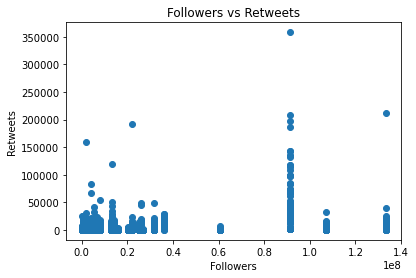

In [71]:
# A scatter plot to show how followers relate to retweets
plt.scatter(df['followers'], df['retweets'])
plt.xlabel('Followers')
plt.ylabel('Retweets')
plt.title('Followers vs Retweets')
plt.show()

We'll clean up these outliers in the main document after combining all of our features.

In [72]:
df.to_csv('data/combined_data.csv')

:)